In [1]:
import utils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from IPython.display import display, HTML
import matplotlib.colors as mcolors
from scipy.stats import shapiro, kruskal
import os

In [2]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

In [3]:
HSPB1_PATH = './data/HSPB1_Sample_handling_RStudio.xlsx'
MMP9_PATH = './data/MMP9_Sample_handling_RStudio.xlsx'
PERM_PATH = './data/PERM_Sample_handling_RStudio.xlsx'

BMKS = ['HSPB1', 'MMP9', 'PERM']

BMKS_PATHS = {
    'HSPB1': HSPB1_PATH,
    'MMP9': MMP9_PATH,
    'PERM': PERM_PATH
}

biomarker_numbers = {
    'MMP9': 1,
    'HSPB1': 2,
    'PERM': 3
}

results_dir = './results/'

# FIGURE 1

In [4]:
def plot_combined_boxplot(df, value_col, group_col, biomarker_col, biomarker_numbers, dunn_results=None):
    df['Biomarker Number'] = df[biomarker_col].map(biomarker_numbers)
    df['Condition Sort Order'] = df[group_col].apply(lambda x: 0 if x == "Reference" else 1)
    df = df.sort_values(by=['Biomarker Number', 'Condition Sort Order', group_col])

    fig, ax = plt.subplots(figsize=(14, 8))
    cmap = plt.get_cmap('Purples')

    current_position = 0
    positions, biomarker_ticks = [], []

    for biomarker in df['Biomarker'].unique():
        biomarker_data = df[df[biomarker_col] == biomarker]
        conditions = biomarker_data[group_col].unique()
        condition_positions = []

        for condition in conditions:
            condition_data = biomarker_data[biomarker_data[group_col] == condition][value_col]
            p_value = dunn_results.get(biomarker, {}).get(condition, 1.0)
            color = cmap(0.25 + (1 - p_value) * 0.5)

            box = ax.boxplot(
                condition_data, positions=[current_position], widths=0.8, patch_artist=True,
                medianprops={'color': 'black'}, whiskerprops={'color': 'black'},
                capprops={'color': 'black'}, boxprops={'edgecolor': 'black', 'facecolor': color},
                flierprops={'markerfacecolor': 'black', 'markeredgecolor': 'black'}
            )

            if p_value != 1.0:
                median_value = np.median(condition_data)
                ax.text(current_position, median_value * 1.05, f"{p_value:.2f}", ha='center', va='bottom', color='black', fontsize=9)

            condition_positions.append(current_position)
            current_position += 1

        midpoint = np.mean(condition_positions)
        biomarker_ticks.append((midpoint, f"Biomarker {biomarker_numbers[biomarker]}"))
        current_position += 1
        positions.extend(condition_positions)

    ax.set_xticks(positions)
    ax.set_xticklabels([row[group_col] for _, row in df.drop_duplicates(subset=['Biomarker Number', group_col]).iterrows()], rotation=45, ha='right')

    for midpoint, label in biomarker_ticks:
        ax.text(midpoint, -0.2, label, ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=12, weight='bold')

    plt.ylabel(r"$\log\left(\frac{[Biomarker]}{[TotalProtein]}\right)$", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{results_dir}/combined_boxplot.svg")
    plt.show()


In [5]:
def display_stat_results(biomarker_label, shapiro_results, kw_stat, kw_p_value, dunn_results_bmk=None):
    display(HTML(f'<h1>{biomarker_label}</h1>'))
    
    shapiro_stats_df = pd.DataFrame.from_dict(shapiro_results, orient='index').reset_index()
    shapiro_stats_df.columns = ['Condition', 'Statistic', 'p-value', 'Normal']
    display(HTML(f'<h3>Shapiro-Wilk Test Results for {biomarker_label}</h3>'))
    display(HTML(shapiro_stats_df.to_html(index=False, border=0, justify='center', col_space='150px')))

    if not all(result['Normal'] for result in shapiro_results.values()):
        display(HTML(f"<p>Not all conditions are normally distributed for {biomarker_label}. Proceeding with Kruskal-Wallis test.</p>"))

    kw_results_df = pd.DataFrame([{'Statistic': kw_stat, 'p-value': kw_p_value, 'Significant': kw_p_value < 0.05}])
    display(HTML(f'<h3>Kruskal-Wallis Test Results for {biomarker_label}</h3>'))
    display(HTML(kw_results_df.to_html(index=False, border=0, justify='center', col_space='150px')))

    if kw_p_value < 0.05:
        display(HTML(f"<p>Significant differences found in Kruskal-Wallis test for {biomarker_label}. Proceeding with Dunn post-hoc test.</p>"))
        if dunn_results_bmk is not None and isinstance(dunn_results_bmk, pd.DataFrame) and not dunn_results_bmk.empty:
            display(HTML(f'<h3>Dunn Test Results for {biomarker_label}</h3>'))
            display(HTML(dunn_results_bmk.to_html(border=0, justify='center', col_space='150px')))
        else:
            display(HTML(f"<p>Dunn Test Results for {biomarker_label} are not available or invalid.</p>"))
    else:
        display(HTML(f"<p>No significant Kruskal-Wallis results for {biomarker_label}, skipping Dunn test.</p>"))


Condition,Statistic,p-value,Normal
Reference,0.946980,0.152718,True
24h 4ºC +PBS,0.893245,0.006776,False
72h 4ºC +PBS,0.900185,0.008487,False
24h 4ºC -PBS,0.908173,0.013387,False
72h 4ºC -PBS,0.964610,0.403895,True


Statistic,p-value,Significant
1.198062,0.878418,False


Condition,Statistic,p-value,Normal
Reference,0.935511,0.084992,True
24h 4ºC +PBS,0.935700,0.077391,True
72h 4ºC +PBS,0.936835,0.074770,True
24h 4ºC -PBS,0.913808,0.018586,False
72h 4ºC -PBS,0.935467,0.068711,True


Statistic,p-value,Significant
9.594946,0.047832,True


,24h 4ºC +PBS,24h 4ºC -PBS,72h 4ºC +PBS,72h 4ºC -PBS,Reference
24h 4ºC +PBS,1.00000,1.000000,1.000000,1.000000,0.574870
24h 4ºC -PBS,1.00000,1.000000,1.000000,1.000000,0.030947
72h 4ºC +PBS,1.00000,1.000000,1.000000,1.000000,0.647593
72h 4ºC -PBS,1.00000,1.000000,1.000000,1.000000,0.211263
Reference,0.57487,0.030947,0.647593,0.211263,1.000000


Condition,Statistic,p-value,Normal
Reference,0.861718,0.001337,False
24h 4ºC +PBS,0.920030,0.030545,False
72h 4ºC +PBS,0.970478,0.552324,True
24h 4ºC -PBS,0.946667,0.137568,True
72h 4ºC -PBS,0.986677,0.962194,True


Statistic,p-value,Significant
1.466767,0.832512,False


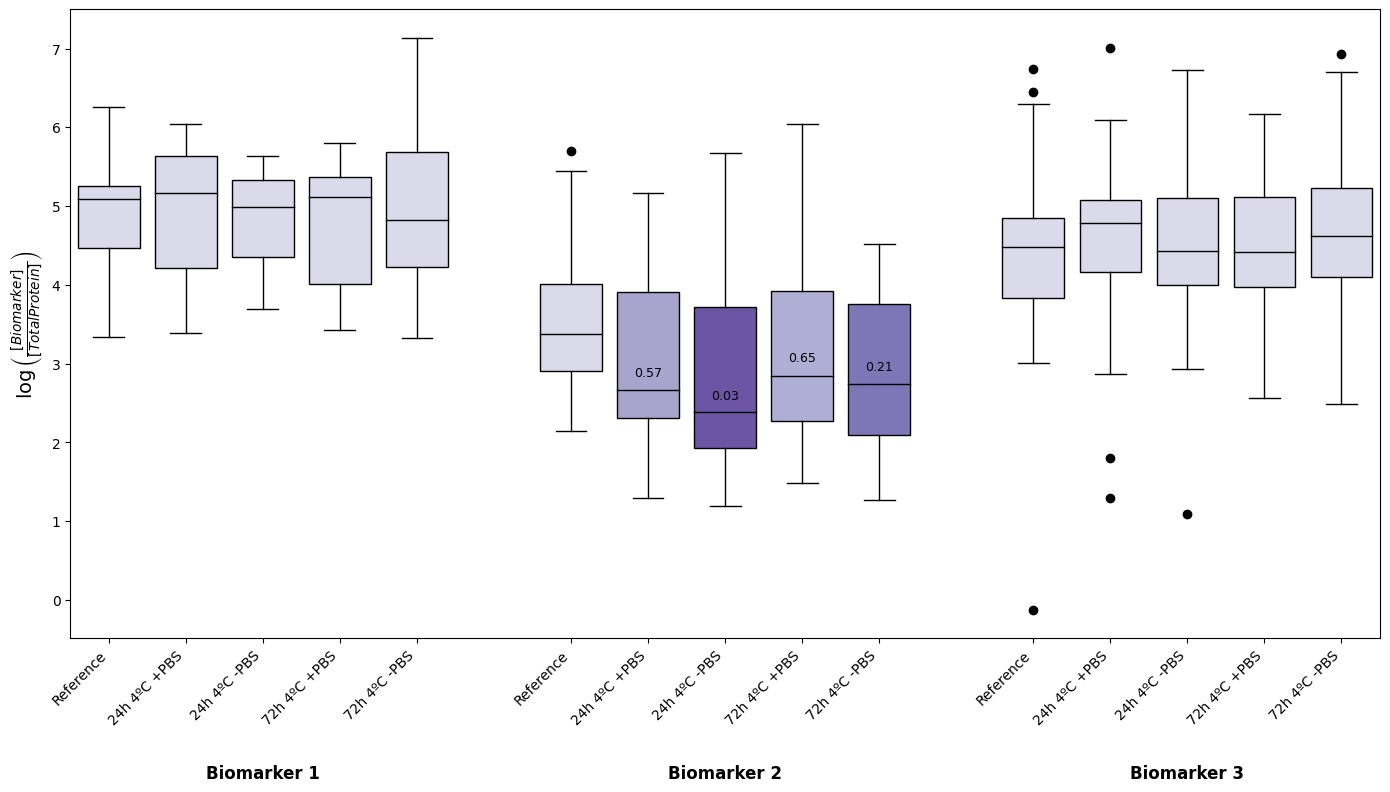

In [6]:

combined_data = []
dunn_results = {}

for bmk in sorted(biomarker_numbers, key=biomarker_numbers.get):
    df = utils.load_and_clean_data(BMKS_PATHS[bmk])
    df['Concentration'] = np.log(df['Concentration'])
    df['Biomarker'] = bmk

    biomarker_number = biomarker_numbers[bmk]
    biomarker_label = f"Biomarker {biomarker_number}"

    shapiro_results = utils.shapiro_wilk_test(df, 'Concentration', 'Condition')
    grouped_data = [group['Concentration'].values for name, group in df.groupby('Condition')]
    kw_stat, kw_p_value = kruskal(*grouped_data)

    dunn_results_bmk = None
    if kw_p_value < 0.05:
        dunn_results_bmk = utils.posthoc_dunn_test(df)
        dunn_results_bmk.to_csv(os.path.join(results_dir, f'{bmk}_dunn_results.csv'), index=True)
        dunn_results[bmk] = dunn_results_bmk['Reference'].to_dict()
    else:
        dunn_results[bmk] = {condition: 1.0 for condition in df['Condition'].unique()}

    display_stat_results(biomarker_label, shapiro_results, kw_stat, kw_p_value, dunn_results_bmk)
    combined_data.append(df)

combined_df = pd.concat(combined_data)

plot_combined_boxplot(
    combined_df,
    value_col='Concentration',
    group_col='Condition',
    biomarker_col='Biomarker',
    biomarker_numbers=biomarker_numbers,
    dunn_results=dunn_results
)


# FIGURE 2

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.stats import wilcoxon, ttest_rel
from IPython.display import display, HTML
from scipy.stats import friedmanchisquare

# Load the Excel file
excel_path = "./data/long_term_stability_study.xlsx"


In [25]:
# Load and preprocess data
def load_and_preprocess_data(filepath):
    df = pd.read_excel(filepath, sheet_name='Results')
    biomarker_numbers = {'MMP9': 1, 'HSPB1': 2, 'PERM': 3}
    df['Biomarker Number'] = df['Biomarker'].map(biomarker_numbers)
    df['t1_month_change'] = ((df['t1 month'] - df['t0']) / df['t0']) * 100
    df['t3_months_change'] = ((df['t3 months'] - df['t0']) / df['t0']) * 100
    return df.dropna(subset=['t0', 't1 month', 't3 months'])

In [42]:
# Perform statistical tests
def perform_statistical_tests(df):
    results = []
    for biomarker in df['Biomarker Number'].unique():
        biomarker_data = df[df['Biomarker Number'] == biomarker]
        t0_values, t1_values, t3_values = biomarker_data['t0'], biomarker_data['t1 month'], biomarker_data['t3 months']

        if len(t0_values) > 1 and not t0_values.equals(t1_values):
            results.append({
                'Biomarker': f'Biomarker {biomarker}',
                ('t0 vs t1', 'Wilcoxon', 'Statistic'): wilcoxon(t0_values, t1_values).statistic,
                ('t0 vs t1', 'Wilcoxon', 'p-value'): wilcoxon(t0_values, t1_values).pvalue,
                ('t0 vs t1', 't-test', 'Statistic'): ttest_rel(t0_values, t1_values).statistic,
                ('t0 vs t1', 't-test', 'p-value'): ttest_rel(t0_values, t1_values).pvalue,
                ('t0 vs t1', 'Friedman', 'Statistic'): friedmanchisquare(t0_values, t1_values, t3_values).statistic,
                ('t0 vs t1', 'Friedman', 'p-value'): friedmanchisquare(t0_values, t1_values, t3_values).pvalue,
                ('t0 vs t3', 'Wilcoxon', 'Statistic'): wilcoxon(t0_values, t3_values).statistic,
                ('t0 vs t3', 'Wilcoxon', 'p-value'): wilcoxon(t0_values, t3_values).pvalue,
                ('t0 vs t3', 't-test', 'Statistic'): ttest_rel(t0_values, t3_values).statistic,
                ('t0 vs t3', 't-test', 'p-value'): ttest_rel(t0_values, t3_values).pvalue,
                ('t0 vs t3', 'Friedman', 'Statistic'): friedmanchisquare(t0_values, t1_values, t3_values).statistic,
                ('t0 vs t3', 'Friedman', 'p-value'): friedmanchisquare(t0_values, t1_values, t3_values).pvalue
            })
    return pd.DataFrame(results)

In [43]:
# Display statistical results
def display_statistical_results(stat_results_df):
    columns = [
        ('Biomarker', '', ''),
        ('t0 vs t1', 'Wilcoxon', 'Statistic'), ('t0 vs t1', 'Wilcoxon', 'p-value'),
        ('t0 vs t1', 't-test', 'Statistic'), ('t0 vs t1', 't-test', 'p-value'),
        ('t0 vs t1', 'Friedman', 'Statistic'), ('t0 vs t1', 'Friedman', 'p-value'),
        ('t0 vs t3', 'Wilcoxon', 'Statistic'), ('t0 vs t3', 'Wilcoxon', 'p-value'),
        ('t0 vs t3', 't-test', 'Statistic'), ('t0 vs t3', 't-test', 'p-value'),
        ('t0 vs t3', 'Friedman', 'Statistic'), ('t0 vs t3', 'Friedman', 'p-value')
    ]
    stat_results_df.columns = pd.MultiIndex.from_tuples(columns)
    html_content = stat_results_df.style.set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center'), ('border', '1px solid darkgrey')]},
         {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid darkgrey')]}]
    ).hide(axis='index').to_html()
    display(HTML('<h3>Statistical Test Results for Each Biomarker</h3>'))
    display(HTML(html_content))


In [44]:
# Plot percentage changes
def plot_percentage_changes(mean_changes):
    fig, ax = plt.subplots(figsize=(5, 6))
    cmap = cm.get_cmap('Purples')
    bar_width = 0.35
    x = np.arange(len(mean_changes))

    ax.barh(x + bar_width / 2, mean_changes['t1_month_mean_change'], color=cmap(0.6), edgecolor='black', height=bar_width, label='t1 Month')
    ax.barh(x - bar_width / 2, mean_changes['t3_months_mean_change'], color=cmap(0.8), edgecolor='black', height=bar_width, label='t3 Months')
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Mean percentage change from t0 (%)')
    ax.set_yticks(x)
    ax.set_yticklabels([f'Biomarker {int(b)}' for b in mean_changes['Biomarker Number']], rotation=30)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"{results_dir}/percentage_changes.svg")
    plt.show()

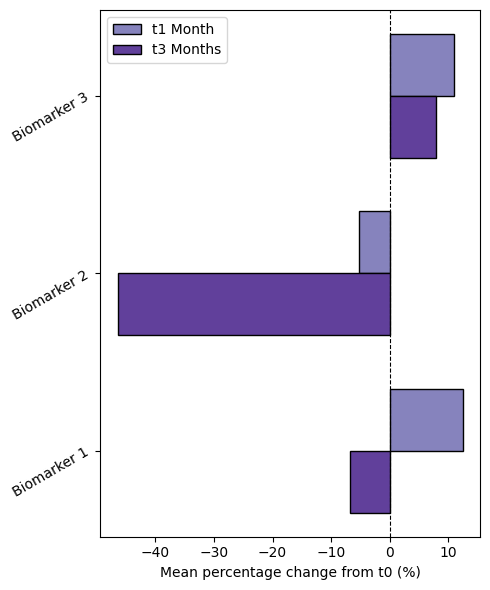

In [45]:
# Main execution
df_clean = load_and_preprocess_data(excel_path)
stat_results_df = perform_statistical_tests(df_clean).sort_values(by='Biomarker')
display_statistical_results(stat_results_df)

mean_changes = df_clean.groupby('Biomarker Number').agg(
    t1_month_mean_change=('t1_month_change', 'mean'),
    t3_months_mean_change=('t3_months_change', 'mean')
).reset_index().sort_values(by='Biomarker Number')

plot_percentage_changes(mean_changes)
